# Combine Lexicons

DS 5001 Text as Data

**Purpose:** Collect all lexicons into a single database.

# Set Up

In [1]:
import sqlite3
import pandas as pd
import re

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [5]:
data_home

'/Users/Samantha/Desktop/MSDS/DS5001/data'

In [6]:
bing_pos_file = data_home + '/lexicons/sources/opinion-lexicon-English/positive-words.txt'
bing_neg_file = data_home + '/lexicons/sources/opinion-lexicon-English/negative-words.txt'
nrc_file = data_home + "/lexicons/sources/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
syuzhet_file = data_home + "/lexicons/sources/syuzhet.csv"
gi_file = data_home + "/lexicons/sources/gi.csv"

# Import Bing lexicon

First, download RAR file from [here](http://sentiment.christopherpotts.net/lexicons.html#opinionlexicon).  Then open in a text editor and convert encoding and line endings in an editor.

In [7]:
bing_list = [(word.strip(), 'bing_positive', 1) 
             for word in open(bing_pos_file, 'r').readlines() 
             if re.match(r'^\w+$', word)]

In [8]:
bing_list += [(word.strip(), 'bing_negative', 1) 
              for word in open(bing_neg_file, 'r').readlines() 
              if re.match(r'^\w+$', word)]

In [9]:
bing = pd.DataFrame(bing_list, columns=['term_str', 'polarity', 'val'])
bing = bing.set_index(['term_str','polarity'])
bing = bing.unstack().fillna(0).astype('int')
bing.columns = bing.columns.droplevel(0)

In [10]:
bing.sum()

polarity
bing_negative    4659
bing_positive    1904
dtype: int64

## Create single sentiment column

In [11]:
bing['bing_sentiment'] = bing['bing_positive'] - bing['bing_negative']

In [12]:
bing.sample(10)

polarity       bing_negative  bing_positive  bing_sentiment
term_str                                                   
hallucination              1              0              -1
incompatible               1              0              -1
fearful                    1              0              -1
bungling                   1              0              -1
obstruction                1              0              -1
bumping                    1              0              -1
floundering                1              0              -1
overthrow                  1              0              -1
dazzling                   0              1               1
dense                      1              0              -1

# Import NRC lexicon

In [13]:
nrc = pd.read_csv(nrc_file, sep='\t', header=None)
nrc.columns = ['term_str','nrc_emotion','val']
nrc = nrc.set_index(['term_str','nrc_emotion'])
nrc = nrc.unstack()
nrc.columns = nrc.columns.droplevel(0)
nrc = nrc[nrc.sum(1) > 1]
nrc.columns = ['nrc_'+col for col in nrc.columns]

In [14]:
nrc.sum().sort_values(ascending=False)

nrc_negative        2366
nrc_fear            1368
nrc_positive        1281
nrc_anger           1208
nrc_sadness         1137
nrc_disgust         1004
nrc_trust            935
nrc_joy              686
nrc_anticipation     682
nrc_surprise         454
dtype: int64

In [15]:
nrc.head()

nrc_anger  nrc_anticipation  nrc_disgust  nrc_fear  nrc_joy  \
term_str                                                                   
abandon              0                 0            0         1        0   
abandoned            1                 0            0         1        0   
abandonment          1                 0            0         1        0   
abduction            0                 0            0         1        0   
aberration           0                 0            1         0        0   

             nrc_negative  nrc_positive  nrc_sadness  nrc_surprise  nrc_trust  
term_str                                                                       
abandon                 1             0            1             0          0  
abandoned               1             0            1             0          0  
abandonment             1             0            1             1          0  
abduction               1             0            1             1          0  
aberration              1             0            0             0          0

In [16]:
nrc['nrc_sentiment'] =nrc.nrc_positive - nrc.nrc_negative

In [17]:
nrc['nrc_sentiment'].sample(10)

term_str
unhappy      -1
illuminate    1
plight       -1
bier         -1
repent        1
broke        -1
practise      1
mentor        1
dirt         -1
weirdo       -1
Name: nrc_sentiment, dtype: int64

# Import Syuzhet lexicon

In [18]:
syu = pd.read_csv(syuzhet_file)
syu.columns = ['id','term_str','syu_sentiment']
syu = syu.drop('id', axis=1)
syu = syu.set_index('term_str')

In [19]:
syu.head()

syu_sentiment
term_str                  
abandon              -0.75
abandoned            -0.50
abandoner            -0.25
abandonment          -0.25
abandons             -1.00

# Import General Inquirer lexicon

This is prepared in a separate notebook.

In [20]:
gi = pd.read_csv(gi_file, index_col=['term_str'])
gi.columns = ['gi_sentiment']

In [21]:
gi.head()

gi_sentiment
term_str                 
abandon                -1
abandonment            -1
abate                  -1
abdicate               -1
abhor                  -1

# Combine all

In [22]:
combo = nrc.join(bing, how='outer')\
    .join(syu, how='outer')\
    .join(gi, how='outer')\
    .sort_index()

In [23]:
combo.shape

(12513, 16)

In [24]:
combo.head()

nrc_anger  nrc_anticipation  nrc_disgust  nrc_fear  nrc_joy  \
term_str                                                                   
abandon            0.0               0.0          0.0       1.0      0.0   
abandoned          1.0               0.0          0.0       1.0      0.0   
abandoner          NaN               NaN          NaN       NaN      NaN   
abandonment        1.0               0.0          0.0       1.0      0.0   
abandons           NaN               NaN          NaN       NaN      NaN   

             nrc_negative  nrc_positive  nrc_sadness  nrc_surprise  nrc_trust  \
term_str                                                                        
abandon               1.0           0.0          1.0           0.0        0.0   
abandoned             1.0           0.0          1.0           0.0        0.0   
abandoner             NaN           NaN          NaN           NaN        NaN   
abandonment           1.0           0.0          1.0           1.0        0.0   
abandons              NaN           NaN          NaN           NaN        NaN   

             nrc_sentiment  bing_negative  bing_positive  bing_sentiment  \
term_str                                                                   
abandon               -1.0            NaN            NaN             NaN   
abandoned             -1.0            NaN            NaN             NaN   
abandoner              NaN            NaN            NaN             NaN   
abandonment           -1.0            NaN            NaN             NaN   
abandons               NaN            NaN            NaN             NaN   

             syu_sentiment  gi_sentiment  
term_str                                  
abandon              -0.75          -1.0  
abandoned            -0.50           NaN  
abandoner            -0.25           NaN  
abandonment          -0.25          -1.0  
abandons             -1.00           NaN

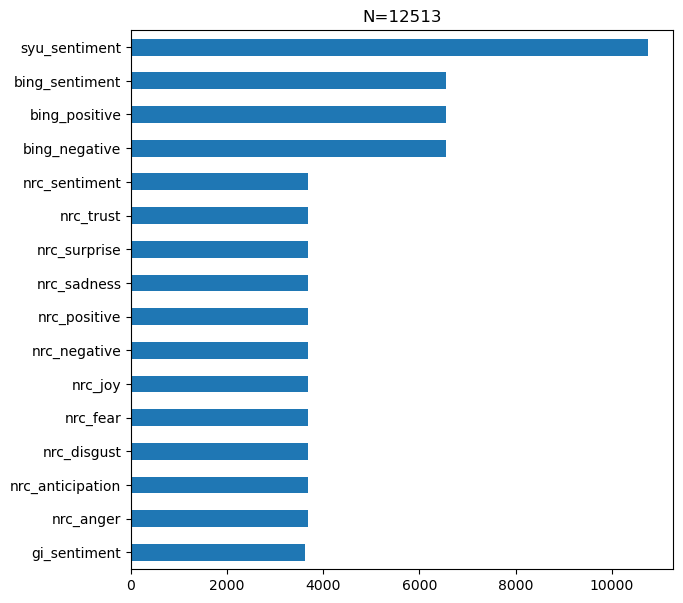

In [25]:
combo.count().sort_values().plot(kind='barh', figsize=(7,7), title='N=' + str(len(combo)));

# Save

In [26]:
nrc.to_csv(data_home + '/lexicons/salex_nrc.csv')
bing.to_csv(data_home + '/lexicons/salex_bing.csv')
syu.to_csv(data_home + '/lexicons/salex_syuzhet.csv')
gi.to_csv(data_home + '/lexicons/salex_gi.csv')
combo.to_csv(data_home + '/lexicons/salex_combo.csv')        